In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import pickle
import sys

In [128]:
# System parameters
gamma_e  = 1.0635e6   # spontaneous decay rate of |e>, s^-1
gamma_f  = 0.0577e6   # spontaneous decay rate of |f>
gamma_ge = 0#0.5117e6   # pure dephasing rate between |g> and |e>
gamma_ef = 0#0.16493413013193#0.2803e6   # pure dephasing rate between |e> and |f>

# Encircling loop parameters
T       = 6e-6       # total period, seconds
dt      = T / 1000    # time step
time = np.arange(0, T + dt, dt)
phase0  = 0
phase   = 2 * np.pi * time / T + phase0
J_EP = (gamma_e - gamma_f) / 4
print("J_EP = ", J_EP)

J_EP =  251450.0


In [3]:
def rabi_tomo(J_drive:float,
              omega:float,
              initial_state:str,):
# Drive detuning and amplitude arrays
    

    def lindblad_rhs(rho, delta, J, ge, gf, gde, gef):
        """Compute dρ/dt for a three-level dissipative system |g>, |e>, |f>."""
        # Collapse operators
        L_e  = np.zeros((3,3), complex)
        L_f  = np.zeros((3,3), complex)
        L_ge = np.zeros((3,3), complex)
        L_ef = np.zeros((3,3), complex)

        L_e[0,1]   = np.sqrt(ge)
        L_f[1,2]   = np.sqrt(gf)
        L_ge[1,1]  = np.sqrt(gde/2)
        L_ef[2,2]  = np.sqrt(gef/2)

        # Effective Hamiltonian in the |e>–|f> subspace
        H = np.array([
            [0,           0,      0     ],
            [0,    delta/2,      J     ],
            [0,  np.conj(J), -delta/2  ]
        ], dtype=complex)

        # Coherent part: -i[H, rho]
        comm = -1j * (H @ rho - rho @ H)

        # Dissipator sum_{k} (L_k ρ L_k† - ½{L_k†L_k, ρ})
        def collapse(L):
            return L @ rho @ L.conj().T - 0.5 * (L.conj().T @ L @ rho + rho @ (L.conj().T @ L))

        return comm + collapse(L_e) + collapse(L_f) + collapse(L_ge) + collapse(L_ef)

    # Initial state: prepare |e> in the {|g>,|e>,|f>} basis
    if initial_state == "e":# |e> in the subspace
        psi_ef = np.array([1, 0], complex)
    elif initial_state == "f":
        psi_ef = np.array([0, 1], complex)
    elif initial_state == "x":
        psi_ef = np.array([1/np.sqrt(2), -1j*1/np.sqrt(2)], complex)
    elif initial_state == "-x":
        psi_ef = np.array([1/np.sqrt(2), 1j*1/np.sqrt(2)], complex)
               
    psi0   = np.array([0, *psi_ef], complex)     # full-state vector
    rho    = np.zeros((3,3,len(time)), complex)
    rho[:,:,0] = np.outer(psi0, psi0.conj())

    # Time evolution via 4th-order Runge–Kutta
    rho_current = rho[:,:,0]
    for i in range(len(time)-1):
        k1 = lindblad_rhs(rho_current, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        k2 = lindblad_rhs(rho_current + 0.5*dt*k1, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        k3 = lindblad_rhs(rho_current + 0.5*dt*k2, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        k4 = lindblad_rhs(rho_current +     dt*k3, omega, J_drive, gamma_e, gamma_f, gamma_ge, gamma_ef)
        rho_current = rho_current + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        rho[:,:,i+1] = rho_current

    # Normalize to the |e>–|f> subspace (post-selection)
    # After your RK4 loop has filled `rho[:,:,i]` for each i...
    P_g = np.real(rho[0,0,:])  # ground state |g> population
    P_e = np.real(rho[1,1,:])  # excited state |e> population
    P_f = np.real(rho[2,2,:])  # second excited |f> population

    rho_ef = np.zeros((2,2,len(time)), complex)
    for i in range(len(time)):
        pop = rho[1,1,i] + rho[2,2,i]
        rho_ef[:,:,i] = rho[1:3,1:3,i] / pop

    # Pauli matrices in the EF subspace
    sigma_x = np.array([[0,1],[1,0]], complex)
    sigma_y = np.array([[0,-1j],[1j,0]], complex)
    sigma_z = np.array([[1,0],[0,-1]], complex)

    # Expectation values
    exp_x = np.real([np.trace(rho_ef[:,:,i] @ sigma_x) for i in range(len(time))])
    exp_y = np.real([np.trace(rho_ef[:,:,i] @ sigma_y) for i in range(len(time))])
    exp_z = np.real([np.trace(rho_ef[:,:,i] @ sigma_z) for i in range(len(time))])


    return exp_x, exp_y, exp_z, rho_ef,P_e, P_f, P_g


In [4]:
def plot_rabi_tomo(df_prob:dict,
                   exp_x:np.ndarray,
                   exp_y:np.ndarray,
                   exp_z:np.ndarray,
                   P_e:np.ndarray,
                   P_f:np.ndarray,
                   P_g:np.ndarray,
                   tomography:str,):
    """Plot the Rabi tomography results."""
    normalized_f= df_prob["P_f"]/(df_prob["P_e"]+df_prob["P_f"])
    if tomography == "z":
        plt.plot(df_prob["time"], df_prob["P_g"]      , 'C0.',  label='Scaled P_g (experiment)')
        plt.plot(df_prob["time"], df_prob["P_e"]      , 'C1.',  label='Scaled P_e (experiment)')
        plt.plot(df_prob["time"], df_prob["P_f"]      , 'C2.',  label='Scaled P_f (experiment)')
        plt.plot(time*1e6, P_g, 'C0'   , label='simulated P_g')
        plt.plot(time*1e6, P_e, 'C1'   , label='simulated P_e')
        plt.plot(time*1e6, P_f, 'C2'   , label='simulated P_f')
        plt.ylabel('Probablity_F')
        plt.ylim(1e-6, 1)
        # plt.xlim(0,8)
        plt.yscale('log')
        plt.xlabel('Time (μs)')
        plt.legend()
        plt.show()
        plt.plot(df_prob["time"], normalized_f,  label='Normalized P_f (experiment)')
        plt.plot(time*1e6,0.5-exp_z/2 , label='Normalized P_f (simulated)')
        plt.xlabel('Time (μs)')
        plt.ylabel('Probablity_F')
        plt.ylim(0, 1)
        # plt.xlim(0,8)
        plt.title('Simulation results') 
        plt.legend()
        plt.show()
    elif tomography == "x":
        plt.plot(df_prob["time"], df_prob["P_g"]      , 'C0.',  label='Scaled P_g (experiment)')
        plt.plot(df_prob["time"], df_prob["P_e"]      , 'C1.',  label='Scaled P_e (experiment)')
        plt.plot(df_prob["time"], df_prob["P_f"]      , 'C2.',  label='Scaled P_f (experiment)')
        plt.plot(time*1e6, P_g, 'C0'   , label='simulated P_g')
        plt.plot(time*1e6, (1-P_g) * (1 + exp_y) / 2, 'C1'   , label='simulated P_e')
        plt.plot(time*1e6, (1-P_g) * (1 - exp_y) / 2, 'C2'   , label='simulated P_f')
        plt.ylabel('Probablity_F')
        plt.ylim(1e-6, 1)
        plt.yscale('log')
        plt.xlabel('Time (μs)')
        plt.legend()
        plt.show()
        plt.plot(df_prob["time"], normalized_f,  label='Normalized P_f (experiment)')
        plt.plot(time*1e6, 0.5- exp_y/2, label='Normalized P_f (simulated)')
        plt.xlabel('Time (μs)')
        plt.ylabel('Probablity_F')
        plt.ylim(0, 1)
        plt.title('Simulation results') 
        plt.legend()
        plt.show()
    elif tomography == "y":
        plt.plot(df_prob["time"], df_prob["P_g"]      , 'C0.',  label='Scaled P_g (experiment)')
        plt.plot(df_prob["time"], df_prob["P_e"]      , 'C1.',  label='Scaled P_e (experiment)')
        plt.plot(df_prob["time"], df_prob["P_f"]      , 'C2.',  label='Scaled P_f (experiment)')
        plt.plot(time*1e6, P_g, 'C0'   , label='simulated P_g')
        plt.plot(time*1e6, (1-P_g) * (1 + exp_x) / 2, 'C1'   , label='simulated P_e')
        plt.plot(time*1e6, (1-P_g) * (1 - exp_x) / 2, 'C2'   , label='simulated P_f')
        plt.ylabel('Probablity_F')
        plt.ylim(1e-6, 1)
        plt.yscale('log')
        plt.xlabel('Time (μs)')
        plt.legend()
        plt.show()
        plt.plot(df_prob["time"], normalized_f,  label='Normalized P_f (experiment)')
        plt.plot(time*1e6, 0.5- exp_x/2, label='Normalized P_f (simulated)')
        plt.xlabel('Time (μs)')
        plt.ylabel('Probablity_F')
        plt.ylim(0, 1)
        plt.title('Simulation results') 
        plt.legend()
        plt.show()
        


In [133]:
df_prob=joblib.load("df_prob_scaled.pkl")

# drive frequency, rad/s
r_list=[1.23]
# tomography="z"
for r in r_list:
    J_drive=r*J_EP
    omega=0.0*1e6*2*np.pi 
    for initial_state in ["e", "f", "x", "-x"]:
        exp_x, exp_y, exp_z, rho_ef,P_e, P_f, P_g = rabi_tomo(J_drive, omega, initial_state)
        # plot_rabi_tomo(df_prob, exp_x, exp_y, exp_z, P_e, P_f, P_g, tomography)
        folder = "non_hermition_simulation_1.23"
        os.makedirs(folder, exist_ok=True)

        # 3) build a descriptive filename
        fname = f"Jdrive={r:.3g}J_ep_state={initial_state}.pkl"
        path  = os.path.join(folder, fname)

        # 4) dump the three arrays into a single pickle
        with open(path, "wb") as f:
            pickle.dump(
                {"exp_x": exp_x, "exp_y": exp_y, "exp_z": exp_z,"rho_ef": rho_ef},
                f
            )
    
 # initial state |e> in the subspace


# print(f"Saved expectations to {path}")

# plt.plot(df_prob["time"], df_prob["P_g"]      , 'C0.',  label='Scaled P_g (experiment)')
# plt.plot(df_prob["time"], df_prob["P_e"]      , 'C1.',  label='Scaled P_e (experiment)')
# plt.plot(df_prob["time"], df_prob["P_f"]      , 'C2.',  label='Scaled P_f (experiment)')
# plt.plot(time*1e6, P_g, 'C0'   , label='simulated P_g')
# plt.plot(time*1e6, P_e, 'C1'   , label='simulated P_e')
# plt.plot(time*1e6, P_f, 'C2'   , label='simulated P_f')
# plt.ylabel('Probablity_F')
# plt.ylim(1e-6, 1)
# plt.yscale('log')
# plt.xlabel('Time (μs)')
# plt.legend()
# plt.show()

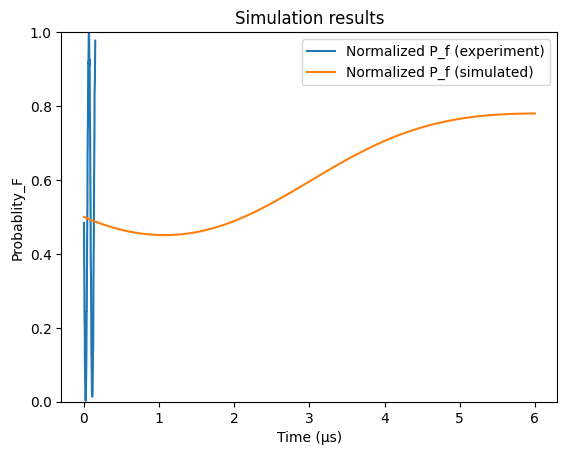

In [6]:

normalized_f= df_prob["P_f"]/(df_prob["P_e"]+df_prob["P_f"])
normalized_f_sim = P_f/(P_e+P_f)
plt.plot(df_prob["time"], normalized_f,  label='Normalized P_f (experiment)')
plt.plot(time*1e6, normalized_f_sim, label='Normalized P_f (simulated)')
plt.xlabel('Time (μs)')
plt.ylabel('Probablity_F')
plt.ylim(0, 1)
plt.title('Simulation results') 
plt.legend()
plt.show()

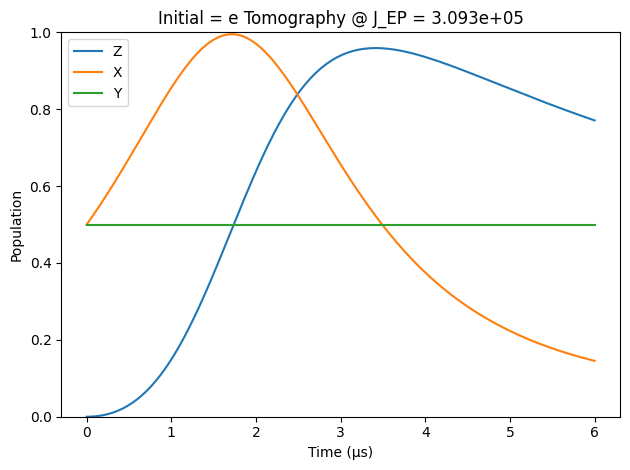

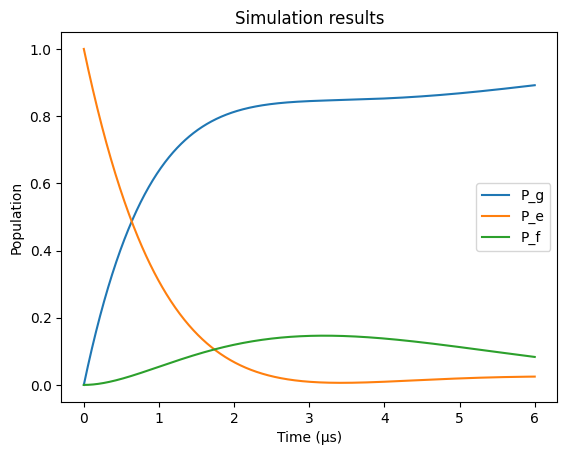

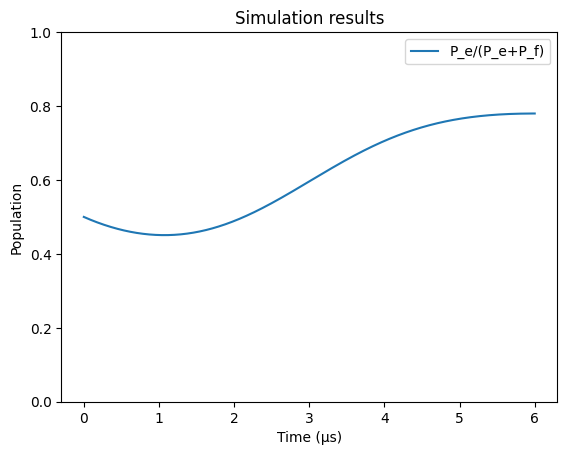

[0.00000000e+00 3.43206136e-06 1.36821307e-05 ... 8.36032905e-02
 8.34320730e-02 8.32609890e-02]
[1.         0.99363589 0.98730546 ... 0.0247288  0.02474218 0.02475534]


In [130]:
# Plot populations = (⟨σ⟩/2 + 0.5)
initial_state="e" # initial state |e> in the subspace
exp_x, exp_y, exp_z, rho_ef,P_e, P_f, P_g = rabi_tomo(J_drive, omega, initial_state)
plt.plot(time*1e6, 0.5-exp_z/2 , label='Z')
plt.plot(time*1e6, 0.5- exp_y/2 , label='X')
plt.plot(time*1e6, 0.5-exp_x/2 , label='Y')

plt.xlabel('Time (μs)')
plt.ylabel('Population')
plt.title(f'Initial = {initial_state} Tomography @ J_EP = {J_drive:.3e}')

plt.ylim(0, 1)
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(time*1e6, P_g, label='P_g')
plt.plot(time*1e6, P_e, label='P_e')
plt.plot(time*1e6, P_f, label='P_f')

plt.xlabel('Time (μs)')
plt.ylabel('Population')
plt.title('Simulation results')
plt.legend()
plt.show()

plt.plot(time*1e6, normalized_f_sim, label='P_e/(P_e+P_f)')
plt.xlabel('Time (μs)')
plt.ylabel('Population')
plt.ylim(0, 1)
plt.title('Simulation results')
plt.legend()
plt.show()
print(P_f)
print(P_e)


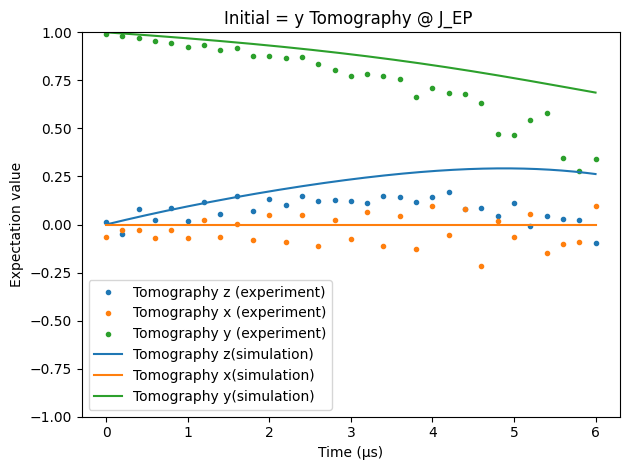

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
initial_state="e" # initial state |e> in the subspace
# 1) Load the CSV
csv_filename ="x_full_tomography_EP(new_x-).csv"#"J=0.28_-x_full_tomography_10000.csv" 
df = pd.read_csv(csv_filename)

# 2) Select only the time and P_f_tomo_{z,x,y} columns
df_pf = df[['time',
            'P_f_tomo_z',
            'P_f_tomo_x',
            'P_f_tomo_y']]

# 3) If you want them as numpy arrays:
times = df_pf['time'].values
pf_z  = df_pf['P_f_tomo_z'].values
pf_x  = df_pf['P_f_tomo_x'].values
pf_y  = df_pf['P_f_tomo_y'].values   
J_drive=1.15*J_EP
initial_state="-x"
omega=0
exp_x, exp_y, exp_z, rho_ef,P_e, P_f, P_g = rabi_tomo(J_drive, omega, initial_state)

plt.plot(times, 1-2*pf_z      , 'C0.',  label='Tomography z (experiment)')
plt.plot(times, 1-2*pf_y      , 'C1.',  label='Tomography x (experiment)')
plt.plot(times, 1-2*pf_x      , 'C2.',  label='Tomography y (experiment)')
plt.plot(time*1e6, exp_z, 'C0'   , label='Tomography z(simulation)')
plt.plot(time*1e6,  exp_x, 'C1'   , label='Tomography x(simulation)')
plt.plot(time*1e6, exp_y, 'C2'   , label='Tomography y(simulation)')
plt.xlabel('Time (μs)')
plt.ylabel('Expectation value')
plt.title(f'Initial = y Tomography @ J_EP ')

plt.ylim(-1, 1)
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

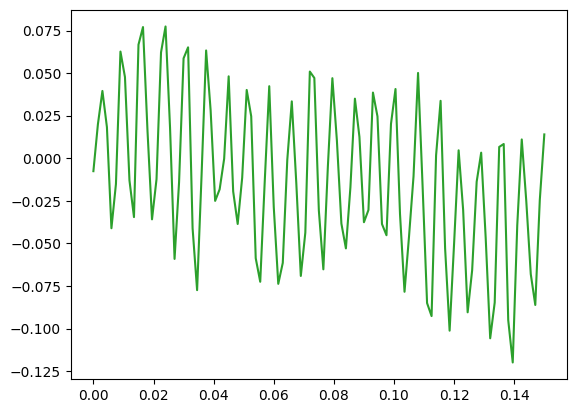

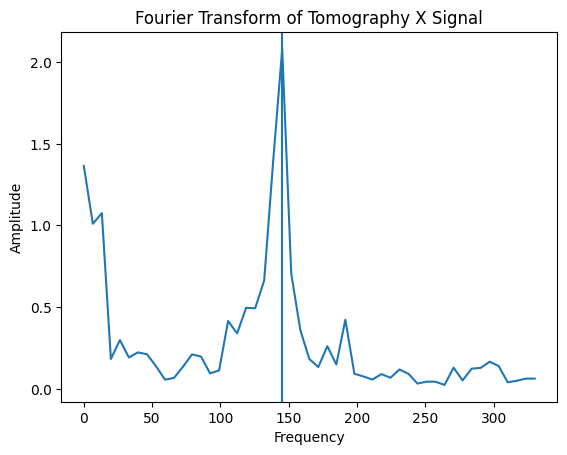

In [106]:
csv_filename ="J=35.70_e_full_tomography_10000.csv"#"x_full_tomography_EP(new_x-).csv"# 
df = pd.read_csv(csv_filename)

# 2) Select only the time and P_f_tomo_{z,x,y} columns
df_pf = df[['time',
            'P_f_tomo_z',
            'P_f_tomo_x',
            'P_f_tomo_y']]

# 3) If you want them as numpy arrays:
times = df_pf['time'].values
pf_z  = df_pf['P_f_tomo_z'].values
pf_x  = df_pf['P_f_tomo_x'].values
pf_y  = df_pf['P_f_tomo_y'].values   
plt.plot(times, 1-2*pf_y      , 'C2',  label='Tomography x (experiment)')
signal = 1 - 2 * pf_y

# Compute sampling interval and FFT
dt = times[1] - times[0]
N = len(signal)
yf = np.fft.fft(signal)
xf = np.fft.fftfreq(N, d=dt)

# Plot only non-negative frequencies
idx = xf >= 0
plt.figure()
plt.plot(xf[idx], np.abs(yf[idx]))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of Tomography X Signal')
plt.axvline(145)
plt.show()
# plt.ylim(-1, 1)

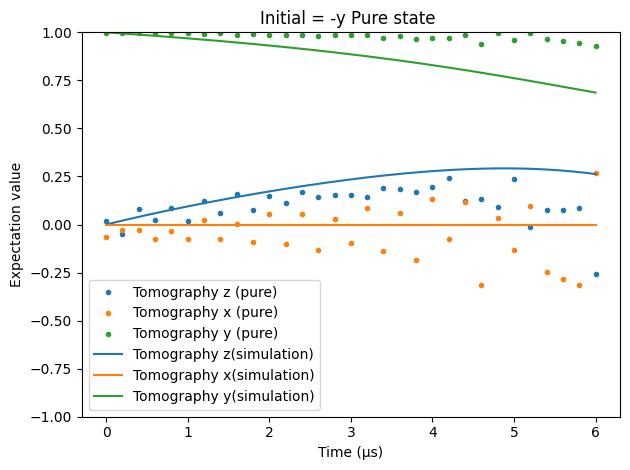

In [123]:
J_drive=1.15*J_EP
initial_state="-x"
omega=0
exp_x, exp_y, exp_z, rho_ef,P_e, P_f, P_g = rabi_tomo(J_drive, omega, initial_state)
df_plus  = pd.read_pickle("plus_x.pkl")
df_minus = pd.read_pickle("minus_x.pkl")
df_e     = pd.read_pickle("e.pkl")
df_f     = pd.read_pickle("f.pkl")
df_plot=df_minus
plt.plot(df_plot["time"], df_plot["exp_z_pure"]      , 'C0.',  label='Tomography z (pure)')
plt.plot(df_plot["time"], df_plot["exp_x_pure"]      , 'C1.',  label='Tomography x (pure)')
plt.plot(df_plot["time"], df_plot["exp_y_pure"]      , 'C2.',  label='Tomography y (pure)')
# plt.plot(times, 1-2*pf_y      , 'C1.',  label='Tomography x (experiment)')
# plt.plot(times, 1-2*pf_x      , 'C2.',  label='Tomography y (experiment)')
plt.plot(time*1e6, exp_z, 'C0'   , label='Tomography z(simulation)')
plt.plot(time*1e6,  exp_x, 'C1'   , label='Tomography x(simulation)')
plt.plot(time*1e6, exp_y, 'C2'   , label='Tomography y(simulation)')
plt.xlabel('Time (μs)')
plt.ylabel('Expectation value')
plt.title(f'Initial = -y Pure state ')

plt.ylim(-1, 1)
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
